# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.creation import CyclicalFeatures

import numpy as np

In [3]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.columns = ['sales']

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.

## Plot time series

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   106 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB


In [5]:
min(df.index)

Timestamp('2009-12-06 00:00:00')

In [6]:
max(df.index)

Timestamp('2011-12-11 00:00:00')

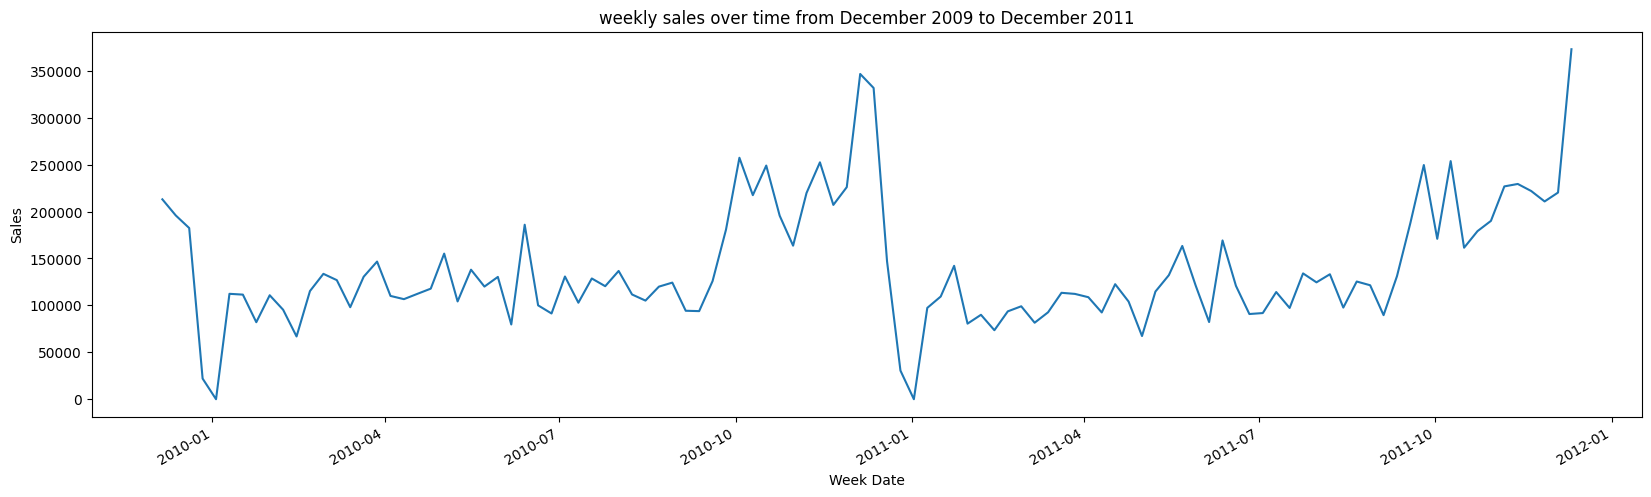

In [9]:
f = plt.figure()
f.set_figwidth(20)
f.set_figheight(5)
plt.plot(df.index, df['sales'])
plt.title('Weekly sales over time from December 2009 to December 2011')
plt.xticks(rotation = 30, ha = 'right')
plt.xlabel('Week Date')
plt.ylabel('Sales')
plt.show()

Based on the plot above, it is evident that there is a general pattern when looking at the bigger picture. 

Additionally, around December of each year, there is a huge spike in weekly sales. 

I believe that there is a clear seasonality trend here, and it is shown by this repetitive patterns and fluctatuions of weekly sales. More specifically, at the start of each year, there is a huge drop in sales relative to prior weeks in previous year, but shortly after the first week of each year, there sales start to go up again. Additionally, at the end of each year, there is a huge spike in weekly sales in around December of each year. Furthermore, sales tend to be have small fluctuations over time for each year from the second week of January up until around September. Subsequently, Sales seem to increase rapidly on the third week of September and dropped on the last week of September of each year. Moreover, weekly sales seem to jump rapidly at the first week of October of each year, dropped a little and increase again around mid October. After that, sales seem to spike steadily in November and rapidly in December. 

This means that we need to make sure that we let the model knows these kind of information later on to account for this. 

I also believe that in this data, there is a trend each year. More specifically, it can be seen that the weekly sales of each year start of very low and throughout the year, the weekly sales steadily rise over time, where it rapidly rises at the end of the year. 

Furthermore, I don't fully see if there is any irregular fluctations over longer time periods, and this could potentially be because we only have around 2 years of data, so not much extensive patterns can be identified. 

Moreover, it is also evident that there is no abnormal observations. For instance, no negative values can be found in the plot above. 

## Missing data

Check if there are missing values in the time series. 

In [13]:
sum(df['sales'].isnull()) # there are no missing values in this time series

0

## Missing timestamps

Check if there are missing timestamps in the index.

In [17]:
# # to check for missing timestamps, I need to first convert the time series to reflect this data that is being measured on weekly basis.
# df_ = df.asfreq('W')

# df_imputed = df_.fillna(method = 'ffill')

# # Plot the imputed time series.
# for var in ['sales', 'week']:

#     # plot the time series.
#     ax = df_[var].plot(linestyle="-", marker=".", figsize=[20, 4])

#     # plot the imputed values on top, in red.
#     df_imputed[df_.isnull()][var].plot(ax=ax, legend=None, marker=".", color="r")

#     # Add title.
#     plt.title(var)

#     # the y axis label
#     plt.ylabel(var)

#     plt.show()

But based on the graph plotted earlier, it is evident that there is no missing timestamps.

## Seasonality

Does the time series show any obvious seasonal pattern?

As mentioned earlier, there seems to be a clear seasonality trend in the graph.

# Feature engineering

Now, let's begin to tabularize the data.

Temporal features

In [24]:
df['Month'] = df.index.month
df['Week'] = df.index.isocalendar().week
df['Day'] = df.index.day

Lagged features

Notably, I will include the following lagged features:

- previous week sales
- previous two weeks sales
- previous month sales
- previous year sales

## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

## Machine Learning